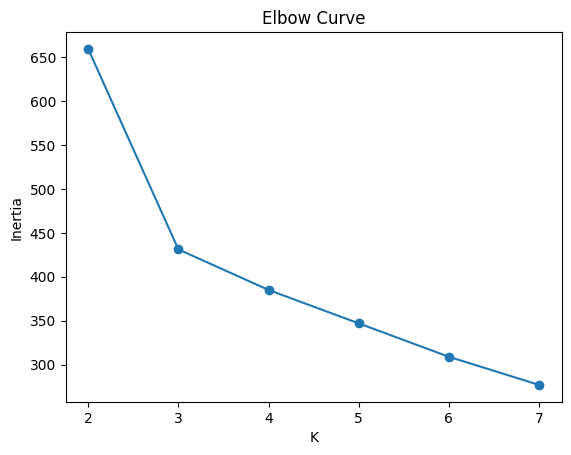

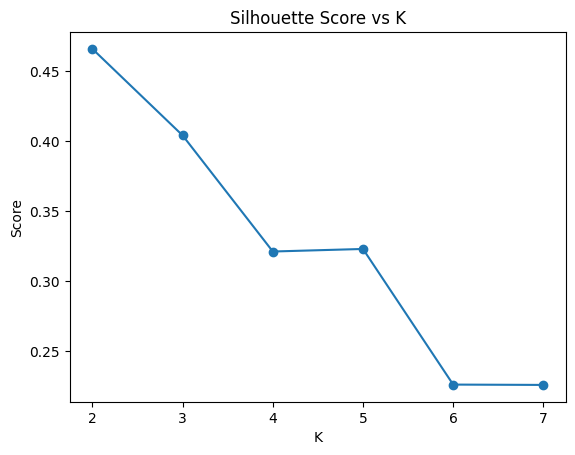

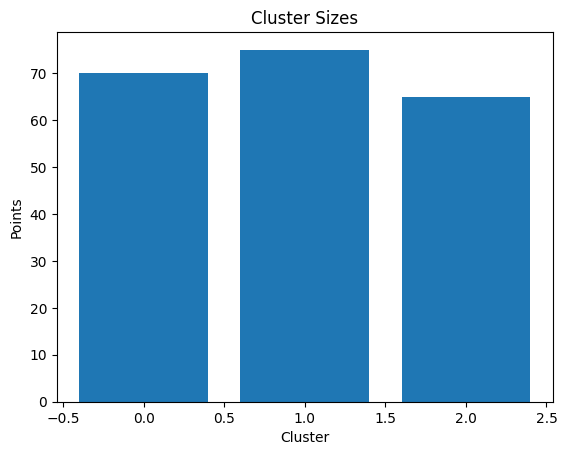

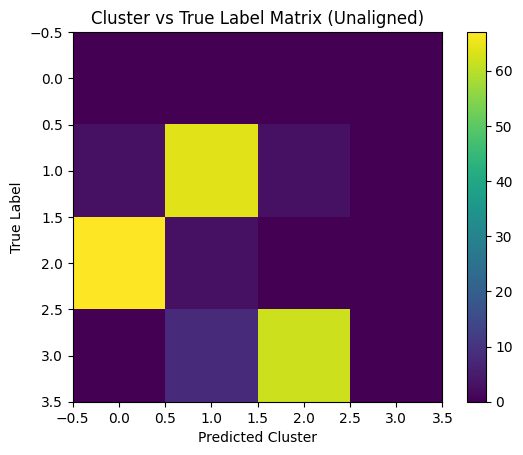

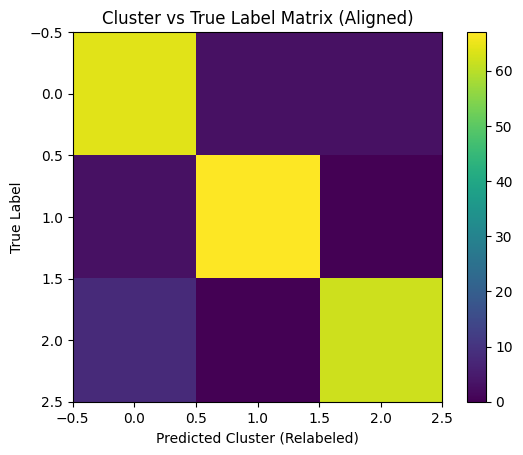

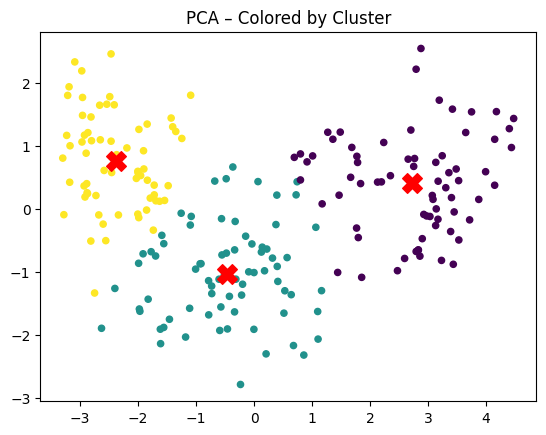

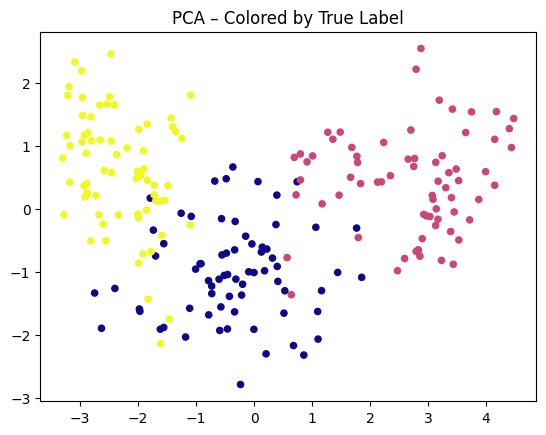

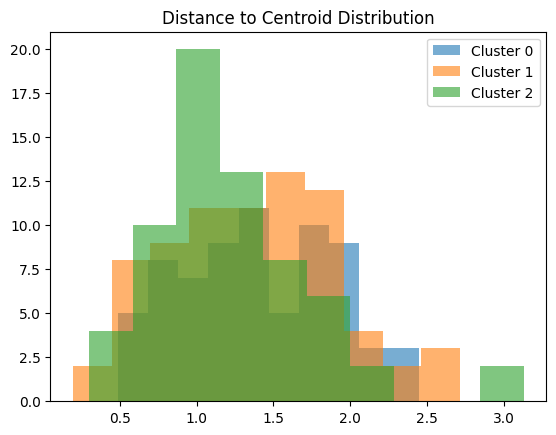

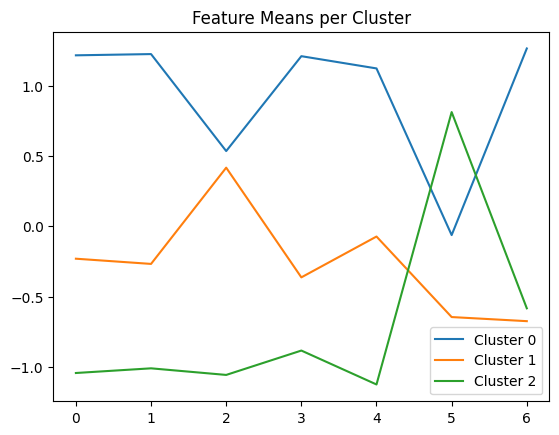

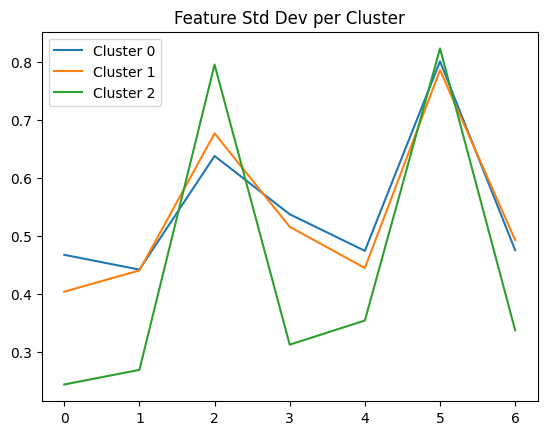

Clustering Accuracy: 0.919047619047619


In [9]:
import numpy as np
import pandas as panda
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, confusion_matrix
from sklearn.decomposition import PCA
from scipy.optimize import linear_sum_assignment


# ------------------ SCALER ------------------
def scaler(x):
    x_scaled = np.zeros_like(x, dtype=float)
    for j in range(x.shape[1]):
        mean = np.mean(x[:, j])
        std = np.std(x[:, j])
        if std == 0:
            std = 1.0              # FIX: avoid divide by zero
        for i in range(x.shape[0]):
            x_scaled[i, j] = (x[i, j] - mean) / std
    return x_scaled


# ------------------ KMEANS ------------------
def generate(z, x):
    for i in range(z.shape[0]):
        z[i] = x[np.random.randint(0, x.shape[0])]
    return z

def assign(z, x):
    y = np.zeros(x.shape[0], dtype=int)
    for i in range(x.shape[0]):
        d = [np.linalg.norm(x[i] - z[k]) for k in range(z.shape[0])]
        y[i] = np.argmin(d)
    return y

def centroid(x, y, z_old):
    z_new = np.zeros_like(z_old)
    for k in range(z_old.shape[0]):
        pts = x[y == k]
        if len(pts) > 0:
            z_new[k] = np.mean(pts, axis=0)
        else:
            z_new[k] = x[np.random.randint(0, x.shape[0])]  # FIX: reinit empty cluster
    return z_new

def inertia(x, y, z):
    return sum(np.linalg.norm(x[i] - z[y[i]])**2 for i in range(len(x)))


# ------------------ LOAD DATA ------------------
data = panda.read_csv(
    "/Users/satviksingh/Documents/manas_projects/classification/seeds_data.csv"
)

x = scaler(data.drop("Class", axis=1).values)
y_true = data["Class"].values


# ------------------ ELBOW + SILHOUETTE ------------------
Ks = range(2, 8)
inertias, silhouettes = [], []

for K in Ks:
    z = generate(np.zeros((K, x.shape[1])), x)

    for _ in range(10):
        y = assign(z, x)
        z = centroid(x, y, z)

    inertias.append(inertia(x, y, z))

    # FIX: guard silhouette computation
    if len(np.unique(y)) == K and len(np.unique(y)) > 1:
        silhouettes.append(silhouette_score(x, y))
    else:
        silhouettes.append(np.nan)


plt.figure()
plt.plot(Ks, inertias, marker='o')
plt.title("Elbow Curve")
plt.xlabel("K")
plt.ylabel("Inertia")
plt.show()

plt.figure()
plt.plot(Ks, silhouettes, marker='o')
plt.title("Silhouette Score vs K")
plt.xlabel("K")
plt.ylabel("Score")
plt.show()


# ------------------ FINAL K=3 ------------------
K = 3
z = generate(np.zeros((K, x.shape[1])), x)

for _ in range(10):
    y = assign(z, x)
    z = centroid(x, y, z)


# ------------------ CLUSTER SIZE ------------------
sizes = [np.sum(y == k) for k in range(K)]

plt.figure()
plt.bar(range(K), sizes)
plt.title("Cluster Sizes")
plt.xlabel("Cluster")
plt.ylabel("Points")
plt.show()


# ------------------ CONFUSION MATRIX (UNALIGNED) ------------------
cm = confusion_matrix(y_true, y)

plt.figure()
plt.imshow(cm)
plt.colorbar()
plt.title("Cluster vs True Label Matrix (Unaligned)")
plt.xlabel("Predicted Cluster")
plt.ylabel("True Label")
plt.show()


# ------------------ CONFUSION MATRIX (ALIGNED) ------------------
# Hungarian algorithm to maximize diagonal
row_ind, col_ind = linear_sum_assignment(-cm)

# mapping: predicted cluster -> true label
label_map = {col: row for row, col in zip(row_ind, col_ind)}

# relabel clusters
y_aligned = np.array([label_map[label] for label in y])

# recompute confusion matrix
cm_aligned = confusion_matrix(y_true, y_aligned)

plt.figure()
plt.imshow(cm_aligned)
plt.colorbar()
plt.title("Cluster vs True Label Matrix (Aligned)")
plt.xlabel("Predicted Cluster (Relabeled)")
plt.ylabel("True Label")
plt.show()



# ------------------ PCA VISUALIZATION ------------------
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x)
z_pca = pca.transform(z)

plt.figure()
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=y, cmap='viridis', s=20)
plt.scatter(z_pca[:, 0], z_pca[:, 1], c='red', marker='X', s=200)
plt.title("PCA – Colored by Cluster")
plt.show()

plt.figure()
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=y_true, cmap='plasma', s=20)
plt.title("PCA – Colored by True Label")
plt.show()


# ------------------ DISTANCE DISTRIBUTION ------------------
plt.figure()
for k in range(K):
    dists = [
        np.linalg.norm(x[i] - z[k])
        for i in range(len(x))
        if y[i] == k
    ]
    plt.hist(dists, alpha=0.6, label=f"Cluster {k}")

plt.legend()
plt.title("Distance to Centroid Distribution")
plt.show()


# ------------------ FEATURE STATS ------------------
means, stds = [], []

for k in range(K):
    means.append(np.mean(x[y == k], axis=0))
    stds.append(np.std(x[y == k], axis=0))

means = np.array(means)
stds = np.array(stds)

plt.figure()
for k in range(K):
    plt.plot(means[k], label=f"Cluster {k}")
plt.title("Feature Means per Cluster")
plt.legend()
plt.show()

plt.figure()
for k in range(K):
    plt.plot(stds[k], label=f"Cluster {k}")
plt.title("Feature Std Dev per Cluster")
plt.legend()
plt.show()

accuracy = np.trace(cm_aligned) / np.sum(cm_aligned)
print("Clustering Accuracy:", accuracy)
